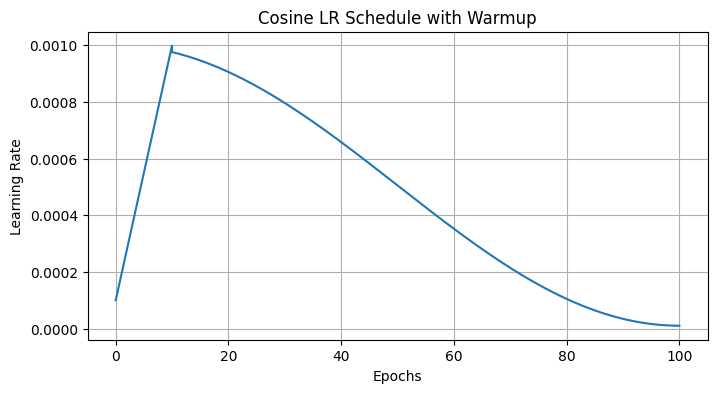

In [2]:
import torch
from timm.scheduler.cosine_lr import CosineLRScheduler
import matplotlib.pyplot as plt

# Dummy optimizer
model = torch.nn.Linear(10, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Simulation parameters
num_epochs = 100
steps_per_epoch = 50  # number of optimizer updates per epoch
total_steps = num_epochs * steps_per_epoch
warmup_fraction = 0.1

# Cosine scheduler
base_lr = 1e-3
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=total_steps,
    lr_min=base_lr * 0.01,
    t_in_epochs=False,  # per-step
    warmup_lr_init=base_lr * 0.1, # type: ignore
    warmup_t=int(total_steps * warmup_fraction),
    warmup_prefix=False,
)

# Track LRs
lrs = []

for epoch in range(num_epochs):
    for step in range(steps_per_epoch):
        # Simulate an optimizer step
        optimizer.step()
        # Step the scheduler
        scheduler.step_update(epoch * steps_per_epoch + step)
        # Record the learning rate
        lrs.append(optimizer.param_groups[0]['lr'])

# Plot LR curve
plt.figure(figsize=(8,4))
plt.plot([i / steps_per_epoch for i in range(total_steps)], lrs)
# plt.plot(range(total_steps), lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Cosine LR Schedule with Warmup')
plt.grid(True)
plt.show()


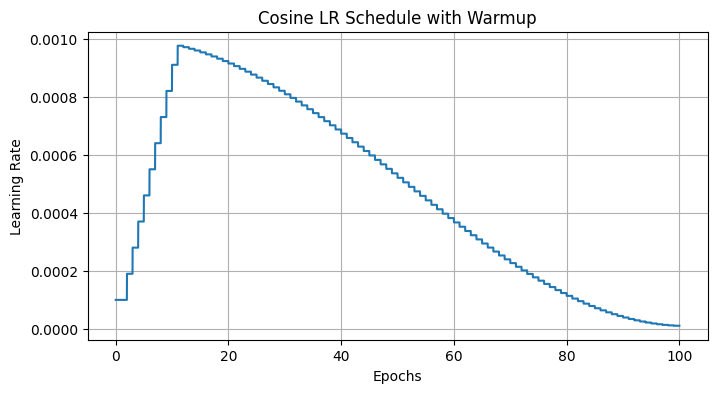

In [8]:
# Simulation parameters
num_epochs = 100
steps_per_epoch = 50  # number of optimizer updates per epoch
warmup_fraction = 0.1

# Cosine scheduler
base_lr = 1e-3
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=base_lr * 0.01,
    t_in_epochs=True,  # per-step
    warmup_lr_init=base_lr * 0.1, # type: ignore
    warmup_t=int(num_epochs * warmup_fraction),
    warmup_prefix=False,
)

# Track LRs
lrs = []

for epoch in range(num_epochs):
    for step in range(steps_per_epoch):
        # Simulate an optimizer step
        optimizer.step()
        # Step the scheduler
        # Record the learning rate
        lrs.append(optimizer.param_groups[0]['lr'])

    scheduler.step(epoch)

# Plot LR curve
plt.figure(figsize=(8,4))
plt.plot([i / steps_per_epoch for i in range(num_epochs * steps_per_epoch)], lrs)
# plt.plot(range(total_steps), lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Cosine LR Schedule with Warmup')
plt.grid(True)
plt.show()


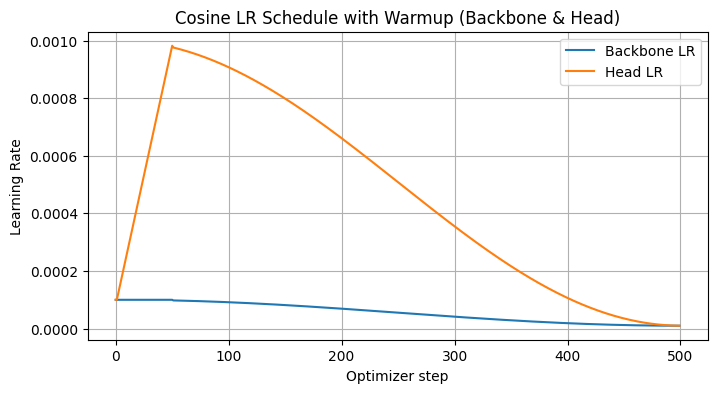

In [ ]:
import torch
from timm.scheduler.cosine_lr import CosineLRScheduler
import matplotlib.pyplot as plt

# Simulate backbone and head parameters
backbone_params = [torch.nn.Parameter(torch.randn(10, 10))]
head_params     = [torch.nn.Parameter(torch.randn(10, 10))]

# Two LR param groups
lr_head = 1e-3
lr_backbone = lr_head * 0.1
optimizer = torch.optim.SGD([
    {"params": backbone_params, "lr": lr_backbone},  # backbone
    {"params": head_params, "lr": lr_head}           # head
], momentum=0.9)

# Training simulation parameters
num_epochs = 10
steps_per_epoch = 50  # optimizer updates per epoch
accumulation_steps = 1
total_steps = num_epochs * steps_per_epoch // accumulation_steps

# Warmup: 10% of total steps
warmup_fraction = 0.1

# Cosine scheduler with per-group warmup
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=total_steps,
    lr_min=lr_head * 0.01,  # applies to both groups
    t_in_epochs=False,  # per-step scheduling
    warmup_lr_init=lr_head * 0.1, # type: ignore
    warmup_t=int(total_steps * warmup_fraction),
    warmup_prefix=False,
)

# Track LRs
lrs_backbone = []
lrs_head = []

for step in range(total_steps):
    # Record LRs for both param groups
    lrs_backbone.append(optimizer.param_groups[0]['lr'])
    lrs_head.append(optimizer.param_groups[1]['lr'])
    
    # Step scheduler (pass cumulative updates)
    scheduler.step_update(num_updates=step)

# Plot
plt.figure(figsize=(8,4))
plt.plot(range(total_steps), lrs_backbone, label='Backbone LR')
plt.plot(range(total_steps), lrs_head, label='Head LR')
plt.xlabel('Optimizer step')
plt.ylabel('Learning Rate')
plt.title('Cosine LR Schedule with Warmup (Backbone & Head)')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from ml_carbucks import RESULTS_DIR
from ml_carbucks.adapters.EfficientDetAdapter import EfficientDetAdapter
from ml_carbucks.utils.DatasetsPathManager import DatasetsPathManager


base_params = {
    "verbose": True,
    "img_size": 256,
    "epochs": 100,
    "batch_size": 32,
}

effdet_no_scheduler = EfficientDetAdapter(**base_params)
effdet_scheduler = EfficientDetAdapter(**base_params, scheduler="cosine")

effdet_no_scheduler.debug(
    train_datasets=DatasetsPathManager.CARBUCKS_TRAIN_STANDARD,
    val_datasets=DatasetsPathManager.CARBUCKS_VAL_STANDARD,
    results_path=RESULTS_DIR / "schedulers",
    results_name="scheduler_no",
)

effdet_scheduler.debug(
    train_datasets=DatasetsPathManager.CARBUCKS_TRAIN_STANDARD,
    val_datasets=DatasetsPathManager.CARBUCKS_VAL_STANDARD,
    results_path=RESULTS_DIR / "schedulers",
    results_name="scheduler_cosine",
)
